# String interning - what, why and how?

This _CCS_ session aims to introduce you to the topic of (string) interning, explaining how it's done in Python specifically, what are the Python internals behind it, why does it work like that and how to benefit from the conscious use of this technique. 

Let's first start with the problem definition.

In [24]:
# Done on Python 3.12, in the Unix-based (Mac) OS
# The _is_ comparison is not a mistake in this case. We want to discuss the result of identity comparison in Python, not value comparison

a: str = 'foo'
b: str = 'foo'

print(f"{a is b=}")

c: str = 'foo!'
d: str = 'foo!'

# Perhaps it's length-based?
print(f"{c is d=}")

e: str = 'foo_'
f: str = 'foo_'

# Huh?
print(f"{e is f=}")

a is b=True
c is d=False
e is f=True


### Prerequistes to understand what we will see

- Python is an **interpreted** language, with the intermediate step of compilation/translation to the bytecode
- Everything in Python is an object, both in the language itself as well as in the interpreter definitions. There's virtually no primitives. (This holds for CPython, but does not have to be true for other interpreters)
- We used _is_ comparison, which is the identity comparison. This effectively checks if one of the defined objects is **exactly the same** (meaning it's memory address is the same) as the second one

In [25]:
# Everyting in Python is an object
a = 5

print(a.is_integer())
print(a.denominator)

True
1


### Breaking things up

So, where do we start? There's not much written in the _str_ class defintion which would be helpful, so we have no real clue about what might be happening besides some basic intuition. In such moments, one of the best things one can do is to deep dive into the internals and dig in the source code.

To do that, we will look into the source code of Python 2.7 specifically as it is less generic than the current Python versions, making it easier for us to understand the mechanism. However, the underlying technique is still present in all the modern Python versions, which we'll try to show.

## Python 2.7 implementation

https://hg.python.org/releasing/2.7.9/file/753a8f457ddc/Include/stringobject.h#l35


```c
typedef struct {
    PyObject_VAR_HEAD
    long ob_shash;
    int ob_sstate;
    char ob_sval[1];

    /* Invariants:
     *     ob_sval contains space for 'ob_size+1' elements.
     *     ob_sval[ob_size] == 0.
     *     ob_shash is the hash of the string or -1 if not computed yet.
     *     ob_sstate != 0 iff the string object is in stringobject.c's
     *       'interned' dictionary; in this case the two references
     *       from 'interned' to this object are *not counted* in ob_refcnt.
     */
} PyStringObject;

```

Specifically, we're interested in the ```ob_sstate``` field. The underlying comment states that: 

```c
    /*
     *     ob_sstate != 0 iff the string object is in stringobject.c's
     *       'interned' dictionary; in this case the two references
     *       from 'interned' to this object are *not counted* in ob_refcnt.
     */
```

Which gives us an idea of what might be happening. Most likely there's a global 'interned' dictionary created every time we run a script, which effectively caches strings. Notice that the information of whether a string is interned or not is a part of the string object. Let's then see how the 'interned' dictionary behaves. To the source code we go!

https://hg.python.org/releasing/2.7.9/file/753a8f457ddc/Objects/stringobject.c#l4745

https://hg.python.org/releasing/2.7.9/file/753a8f457ddc/Objects/stringobject.c#l4732

```c
PyString_InternInPlace(PyObject **p)
{
    register PyStringObject *s = (PyStringObject *)(*p);
    PyObject *t;
    if (s == NULL || !PyString_Check(s))
        Py_FatalError("PyString_InternInPlace: strings only please!");
    /* If it's a string subclass, we don't really know what putting
       it in the interned dict might do. */
    if (!PyString_CheckExact(s))
        return;
    if (PyString_CHECK_INTERNED(s))
        return;
    if (interned == NULL) {
        interned = PyDict_New();
        if (interned == NULL) {
            PyErr_Clear(); /* Don't leave an exception */
            return;
        }
    }
    t = PyDict_GetItem(interned, (PyObject *)s);
    if (t) {
        Py_INCREF(t);
        Py_DECREF(*p);
        *p = t;
        return;
    }
    
    if (PyDict_SetItem(interned, (PyObject *)s, (PyObject *)s) < 0) {
        PyErr_Clear();
        return;
    }
    /* The two references in interned are not counted by refcnt.
       The string deallocator will take care of this */
    Py_REFCNT(s) -= 2;
    PyString_CHECK_INTERNED(s) = SSTATE_INTERNED_MORTAL;
}
```

We can see that keys in the interned dictionary are actually pointers to string objects and values are the same pointers. Furthermore, string subclasses are _NOT_ interned. We can try to show the idea behind this function in a pseudo Python code:

In [26]:
interned = None

def intern(string):
    if string is None or not type(string) is str:
        raise TypeError

    if string.is_interned:
        return string

    if interned is None:
        interned = {}

    t = interned.get(string)
    if t is not None:
        return t

    interned[string] = string
    string.is_interned = True
    return string

### But why is it beneficial to intern strings?

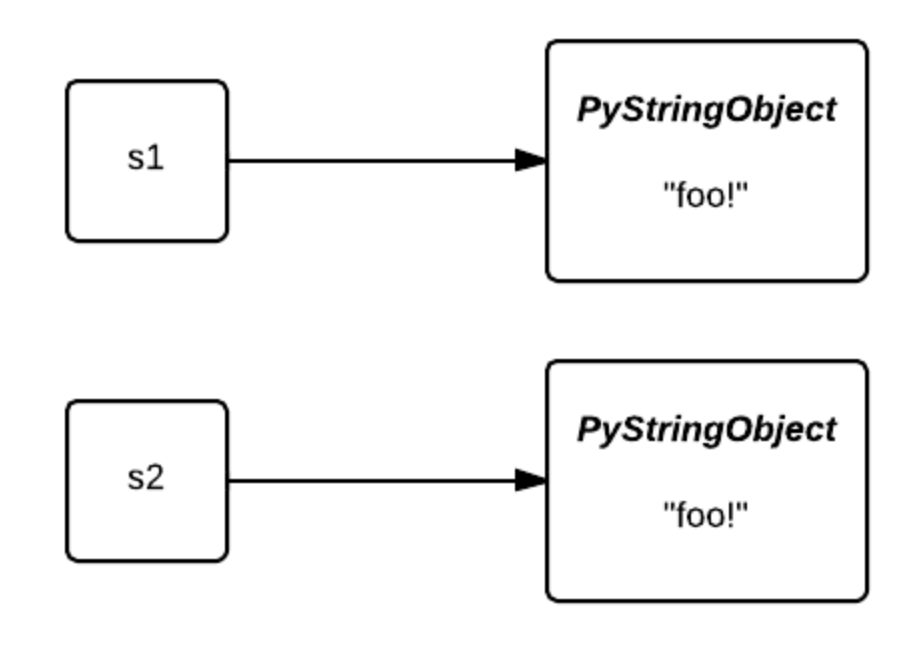

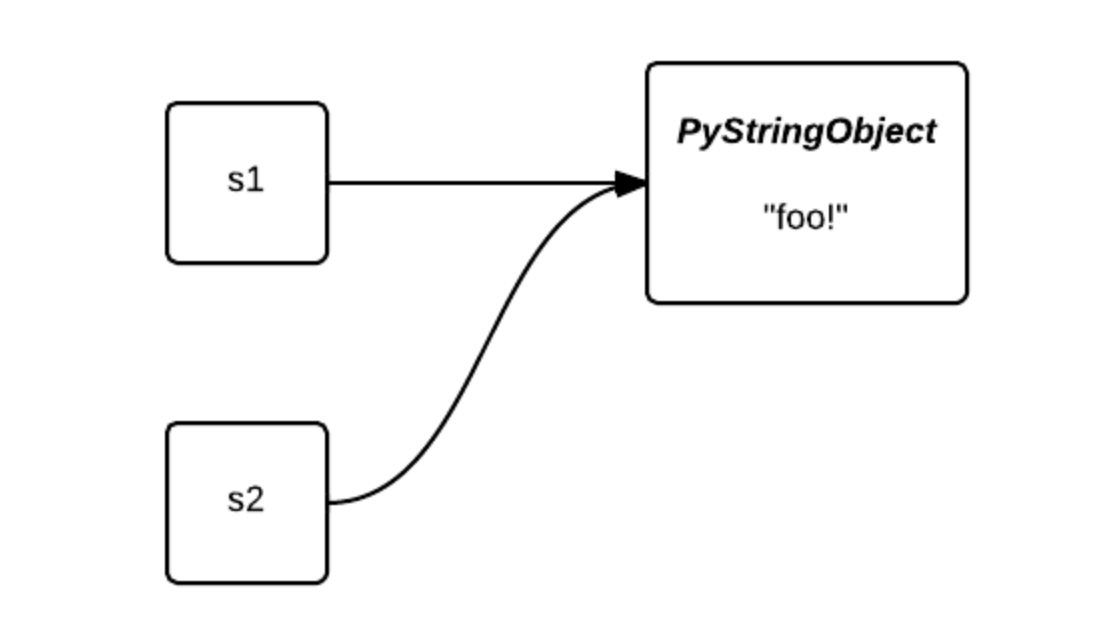

When dealing with large lists with low entropy, interning makes a lot of sense. You can imagine that you are trying to for example tokenize a text corpus - in such a scenario you'd benefit from the heavy-tailed distribution of word frequencies in human languages when interning strings. Let's see an example and inspect the interpreter's heap

In [27]:
%pip install nltk
%pip install guppy3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# For some reason guppy has problems when ran from jupyter notebook, if you want to see benefits of interning by yourself put the below code in a separate script

import guppy
import nltk
import sys

heap = guppy.hpy()
heap.setrelheap()

nltk.download('genesis')

gen = nltk.corpus.genesis.words()
print(heap.heap())

gen = [sys.intern(word) for word in nltk.corpus.genesis.words()]
print(heap.heap())

# It's harder to show clear results in Python 3.x, as there's a lot of object noise because of how lists are implemented, however a similar experiment in Python 2.7 would yield the following results:

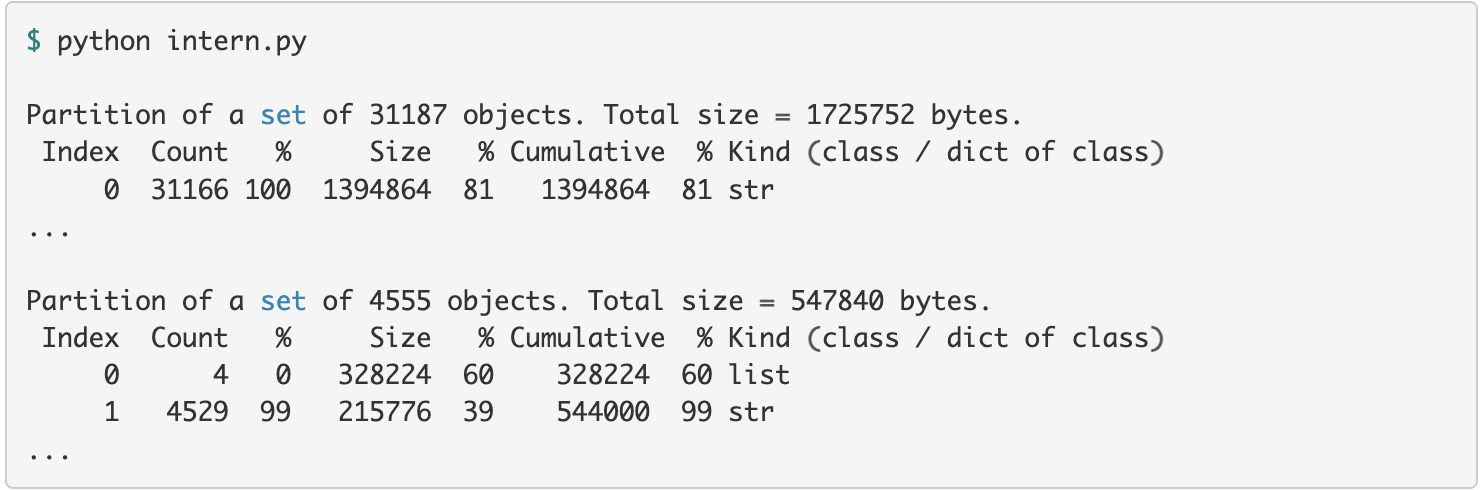

Which results in over 6.5x memory saving!

### Pointer comparison

Besides the memory optimization, because of the pointer comparison we are able to compare strings in the _O(1)_ time, rather than _O(n)_ which would typically happen in the byte-to-byte comparison.

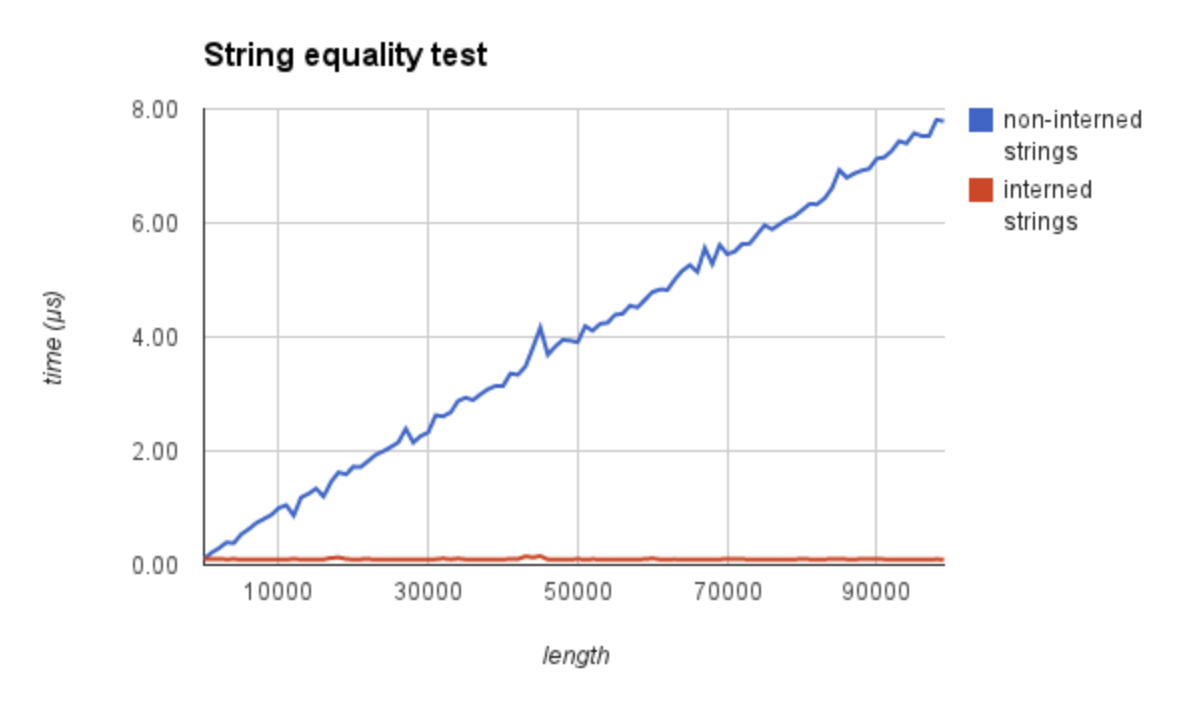

## Ok, but why did Python omit the 'foo!' string when interning, but it did not omit 'foo_'?

Yes, this is still a question that we didn't answer and I know that it can be bugging your mind. Let's tackle it now.

The proper intuition we gained from the beggining examples is that string interning rules are based on:
- string's length
- characters that the string is made of

And it's not far from truth! However, infering the whole ruleset from examples is quite hard. Let's give it a shot

In [27]:
# Supress syntax warnings
import warnings
warnings.filterwarnings("ignore")


a: str = "foo"
b: str = "foo"
print(f"{a is b=}")

c: str = "foo!"
d: str = "foo!"
print(f"{c is d=}")

e: str = "foo_"
f: str = "foo_"
print(f"{e is f=}")



print(f"{'foo' + 'bar' is 'foobar'=}")
print(f"{''.join(['f']) is ''.join(['f'])=}")
print(f"{''.join(['f', 'o', 'o']) is ''.join(['f', 'o', 'o'])=}")
print(f"{'a' * 20 is 'aaaaaaaaaaaaaaaaaaaa'=}")
print(f"{'a' * 21 is 'aaaaaaaaaaaaaaaaaaaaa'=}") # This would yield False in Python 2.7 because of much more strict interning rules.
print(f"{'foooooooooooooooooooooooooooooo' is 'foooooooooooooooooooooooooooooo'=}") 

a is b=True
c is d=False
e is f=True
'foo' + 'bar' is 'foobar'=True
''.join(['f']) is ''.join(['f'])=True
''.join(['f', 'o', 'o']) is ''.join(['f', 'o', 'o'])=False
'a' * 20 is 'aaaaaaaaaaaaaaaaaaaa'=True
'a' * 21 is 'aaaaaaaaaaaaaaaaaaaaa'=True
'foooooooooooooooooooooooooooooo' is 'foooooooooooooooooooooooooooooo'=True


### Fact 0: all length 0 and length 1 strings are interned

This no longer is kept in the Python 3.x, but was how it worked in Python 2.7

```c
/* share short strings */
if (size == 0) {
    PyObject *t = (PyObject *)op;
    PyString_InternInPlace(&t);
    op = (PyStringObject *)t;
    nullstring = op;
    Py_INCREF(op);
} else if (size == 1 && str != NULL) {
    PyObject *t = (PyObject *)op;
    PyString_InternInPlace(&t);
```

### Fact 1: strings are interned at compile time

The Python code you write is not directly interpreted and goes through a classic compilation chain which generates an intermediate language called bytecode. Python bytecode is a set of instructions executed by a virtual machine: the Python interpreter. The list of these instructions can be found [here](https://docs.python.org/3/library/dis.html#bytecodes)

In [29]:
import dis

def foo():
    print('foo')

dis.dis(foo)

  3           0 RESUME                   0

  4           2 LOAD_GLOBAL              1 (NULL + print)
             12 LOAD_CONST               1 ('foo')
             14 CALL                     1
             22 POP_TOP
             24 RETURN_CONST             0 (None)


As we said earlier, everything in Python is an object. This is also true for so called Code objects which represent pieces of bytecode. A Code object carries along all the information needed to execute: constants, variable names and so on. It turns out that when building a Code object in Python, some more strings are interned:

https://hg.python.org/releasing/2.7.9/file/753a8f457ddc/Objects/codeobject.c#l72

```c
PyCodeObject *
PyCode_New(int argcount, int nlocals, int stacksize, int flags,
           PyObject *code, PyObject *consts, PyObject *names,
           PyObject *varnames, PyObject *freevars, PyObject *cellvars,
           PyObject *filename, PyObject *name, int firstlineno,
           PyObject *lnotab)

           ...
           /* Intern selected string constants */
           for (i = PyTuple_Size(consts); --i >= 0; ) {
               PyObject *v = PyTuple_GetItem(consts, i);
               if (!PyString_Check(v))
                   continue;
               if (!all_name_chars((unsigned char *)PyString_AS_STRING(v))) /* <--- */
                   continue;
               PyString_InternInPlace(&PyTuple_GET_ITEM(consts, i));
           }
```
The ```consts``` contains literals defined at compile time: booleans, floats, integers and strings that are declared in our program. The strings stored in this tuple and not filtered out by the all_name_chars function are interned.

Knowing this it is important to understand what's happening at the compile time and what belongs to the runtime. For reference, s1 in the example below would be declared at compile time, whereas s2 would be produced at runtime.

In [30]:
s1 = 'foo' # compile time, interned
s2 = ''.join(['f', 'o', 'o']) # runtime, not interned

s1 is s2

False

The function all_name_chars rules out strings that are not composed of ascii letters, digits or underscores, i.e. strings looking like identifiers:

```c
#define NAME_CHARS \
    "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz"

/* all_name_chars(s): true iff all chars in s are valid NAME_CHARS */

static int
all_name_chars(unsigned char *s)
{
    static char ok_name_char[256];
    static unsigned char *name_chars = (unsigned char *)NAME_CHARS;

    if (ok_name_char[*name_chars] == 0) {
        unsigned char *p;
        for (p = name_chars; *p; p++)
            ok_name_char[*p] = 1;
    }
    while (*s) {
        if (ok_name_char[*s++] == 0)
            return 0;
    }
    return 1;
}
```

With all these explanations in mind, we now understand why 'foo!' is 'foo!' evaluates to False whereas 'foo' is 'foo' evaluates to True. Victory? Not quite yet.

### Bytecode optimization

It might sound very counterintuitive, but in the example below, the outcome of the string concatenation is not performed at runtime but at compile time:

In [31]:
'foo' + 'bar' is 'foobar'

True

This is why the result of 'foo' + 'bar' is also interned and the expression evaluates to True.

How? The penultimate source code compilation step produces a first version of bytecode. This “raw” bytecode finally goes into a last compilation step called “peephole optimization”.

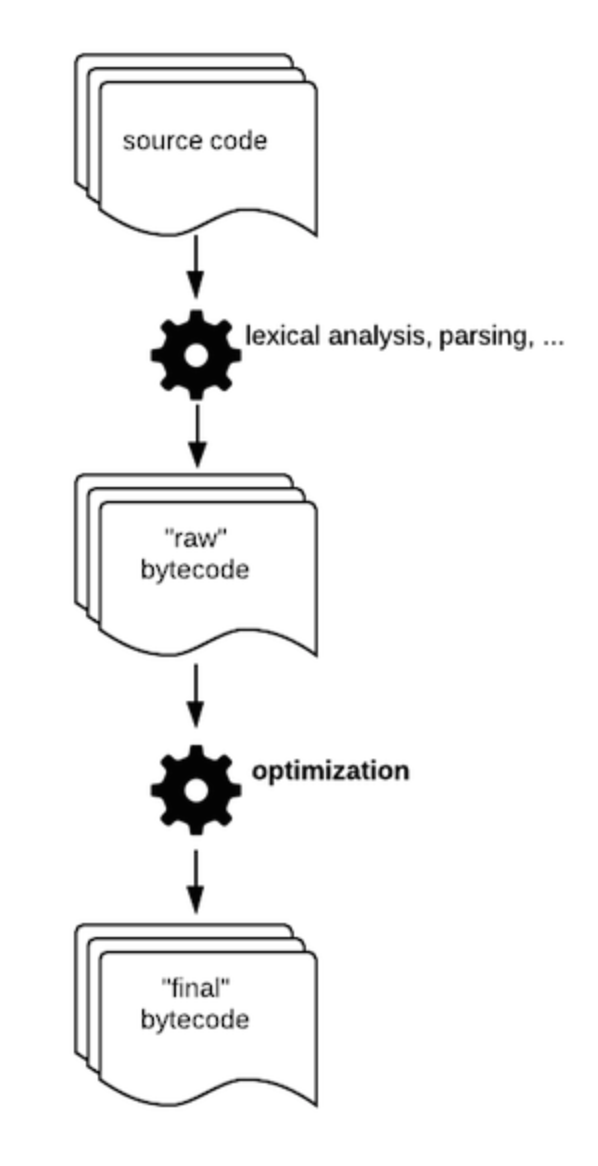

### Constant folding

One of the techniques applied during optimization is called constant folding and consists in simplifying constant expressions in advance. Imagine you are a compiler and you come across this line:

```SECONDS = 24 * 60 * 60```

What can you do to simplify this expression and save some clock cycles at runtime? You are going to substitute this expression by the computed value 86400. This is exactly what happens to the 'foo' + 'bar' expression. Let’s define the foobar function and disassemble the corresponding bytecode:

In [32]:
import dis

def foobar():
    return 'foo'+'bar'

dis.dis(foobar)



  3           0 RESUME                   0

  4           2 RETURN_CONST             1 ('foobar')


In [33]:
# That is why this evaluates to True 

'a' * 20 is 'aaaaaaaaaaaaaaaaaaaa'


True

#### Appendix

This works only because Python strings are immutable - of course, because they need to be HashMap's keys. An interesting fact is that also some of the integers are quasi-interned. First 256 integers are cached at the beginning of the runtime, also landing in the interned dictionary.

In [37]:
x = 256
y = 256

x is y

True

In [36]:
w = 257
z = 257

w is z

False

#### Additional sources

Python 3.x string (unicode) object definition:
https://github.com/python/cpython/blob/main/Include/internal/pycore_unicodeobject.h

Exploring Python Code Objects:
https://late.am/post/2012/03/26/exploring-python-code-objects

Overview of string implementation:
https://www.laurentluce.com/posts/python-string-objects-implementation/

Python optimizers docs:
https://legacy.python.org/workshops/1998-11/proceedings/papers/montanaro/montanaro.html



Big thanks to #guilload from whom I've first seen those things (and anarchoinfo'd some of the parts):
https://guilload.com/python-string-interning